# Plot time evolution of distance between true brownian trajectories

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy import signal, stats
from sklearn import decomposition, linear_model
import sys
import warnings; warnings.filterwarnings("ignore")

from aux import get_seg, rand_string
from disp import set_plot, plot_b, colors, get_line_log
from my_stats import nanpearsonr

cc = np.concatenate

FPS = 30.03  # sampling rate of behavioral data
DT = 1/FPS

Load natural song snippets

In [2]:
STRAINS = ['NM91', 'ZH23']
FSTRAIN = 'data/simple/strains.csv'

MSTRAINS = [(pd.read_csv(FSTRAIN)['STRAIN'] == strain) for strain in STRAINS]
MSTRAIN = np.any(MSTRAINS, axis=0)
ISTRAIN = MSTRAIN.nonzero()[0]

NTR = MSTRAIN.sum()

In [3]:
# load natural songs
df_song = pd.read_csv('data/simple/c_song_f_behav.csv')[['ID', 'T', 'Q', 'S', 'P' ,'F']]
sngs_full = []
for itr in ISTRAIN:
    df_tr = df_song[df_song['ID'] == itr]
    sng_full = np.zeros(len(df_tr), dtype=int)
    sng_full[df_tr['S'] == 1] = 1
    sng_full[(df_tr['P'] == 1) | (df_tr['F'] == 1)] = 2
    sngs_full.append(sng_full)

In [4]:
N = 20
tau_r = np.random.uniform(120, 120, N)
tau_a = np.random.uniform(.1, 2, N)
x_s = np.random.uniform(0, 1, N)
x_p = np.random.uniform(0, 1, N)

In [5]:
def smlt(i_s, i_p, tau_r, tau_a, x_s, x_p):
    t = np.arange(len(i_s))*DT
    n = len(tau_a)
    
    vs = np.nan*np.zeros((len(t), n))
    vs[0, :] = 0
    
    rs = np.nan*np.zeros((len(t), n))
    rs[0, :] = 0
    
    a_ss = np.zeros((len(t), n))
    a_ps = np.zeros((len(t), n))
    
    for ct in range(1, len(t)):
        
        # update adapted input
        vs[ct, :] = x_s*(1-a_ss[ct-1, :])*i_s[ct] + x_p*(1-a_ps[ct-1, :])*i_p[ct]
        
        # update integrated response
        rs[ct, :] = rs[ct-1, :] + (DT/tau_r)*(-rs[ct-1, :] + vs[ct, :])
        
        # update adaptation variables
        a_ss[ct, :] = a_ss[ct-1, :] + (DT/tau_a)*(-a_ss[ct-1, :] + i_s[ct])
        a_ps[ct, :] = a_ps[ct-1, :] + (DT/tau_a)*(-a_ps[ct-1, :] + i_p[ct])
        
    return rs, vs, a_ss, a_ps, t

In [6]:
# get snippets
T_SEG = 300
NT_SEG = int(round(T_SEG*FPS))

T_GAP = 10e10
NT_GAP = int(round(T_GAP*FPS))

t = np.arange(NT_SEG)*DT

segs = []

for csng, sng_full in enumerate(sngs_full):

    bds = get_seg(sng_full > 0, min_gap=NT_GAP)[1]
    segs_ = [sng_full[lb:ub] for lb, ub in bds]

    # keep fixed-length portions only of sufficiently long segments
    segs_ = [seg[:NT_SEG] for seg in segs_ if (len(seg) >= NT_SEG)]
    
    segs.extend(segs_)
    
nseg = len(segs)
print(f'{nseg} segments of duration {T_SEG}')

57 segments of duration 300


In [7]:
rs = np.nan*np.zeros((len(segs), len(t), N))
for cseg, seg in enumerate(segs):
    
    rs_ = (.1+ np.random.randn(len(seg), N)).cumsum(axis=0)
    rs[cseg, :, :] = rs_

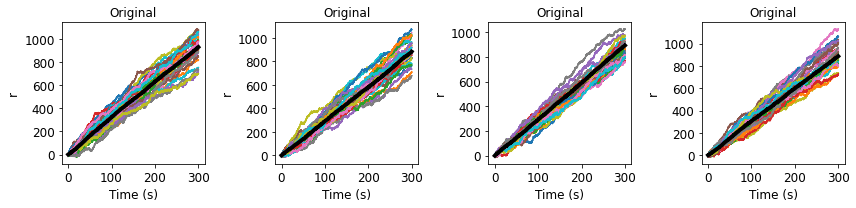

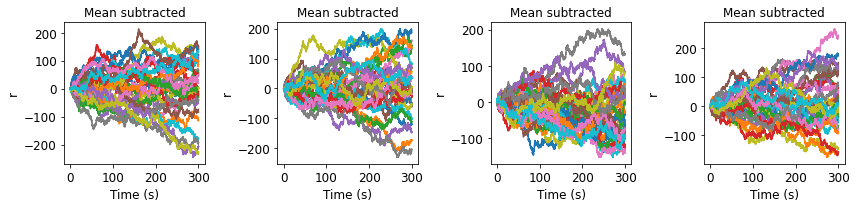

In [8]:
N_SEG_PLOT = 30
rs_mn = rs.mean(axis=0)
rs_mn_zero = rs - rs_mn

fig, axs = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True)
for cseg in range(N_SEG_PLOT):
    for cax, ax in enumerate(axs):
        ax.plot(t, rs[cseg, :, cax])
        
for cax, ax in enumerate(axs):
    ax.plot(t, rs_mn[:, cax], c='k', lw=4)
    set_plot(ax, x_label='Time (s)', y_label='r', title='Original')
    
fig, axs = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True)
for cseg in range(N_SEG_PLOT):
    for cax, ax in enumerate(axs):
        ax.plot(t, rs_mn_zero[cseg, :, cax])
        
for cax, ax in enumerate(axs):
    set_plot(ax, x_label='Time (s)', y_label='r', title='Mean subtracted')

In [9]:
# compute rms displacement of zero-mean trajectories
rmsds = np.nan*np.zeros((nseg, len(t)))

for cseg in range(nseg):
    rmsds[cseg, :] = np.linalg.norm(rs_mn_zero[cseg, :, :], axis=1)

Slope = 0.47668378338835093


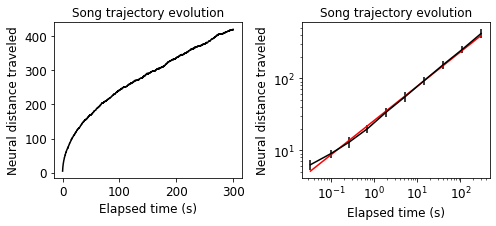

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3.25), tight_layout=True)
axs[0].plot(t, rmsds.mean(0), c='k')
mt = np.round(np.logspace(0, np.log10(len(t)-1), 10)).astype(int)
axs[1].errorbar(t[mt], rmsds.mean(0)[mt], yerr=np.std(rmsds, axis=0)[mt], c='k')

x_ln, y_ln, (slp, icpt, r, p, sterr) = get_line_log(t[t>0], rmsds.mean(0)[t>0])

axs[1].plot(10**x_ln, 10**y_ln, c='r')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

# axs[1].grid()

for ax in axs:
    set_plot(ax, x_label='Elapsed time (s)', y_label='Neural distance traveled', title='Song trajectory evolution')

print(f'Slope = {slp}')

In [11]:
# song separation
NPAIR = 50

ds = np.nan*np.zeros((NPAIR, len(t)))
for cpair in range(NPAIR):
    idx_0, idx_1 = np.random.choice(np.arange(nseg), 2, replace=False)
    ds[cpair, :] = np.linalg.norm(rs[idx_0, :, :]-rs[idx_1, :, :], axis=1)

Slope = 0.47249931879769835


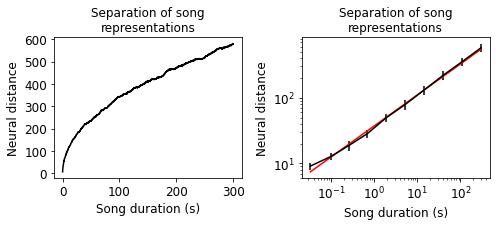

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3.25), tight_layout=True)
axs[0].plot(t, ds.mean(0), c='k')
mt = np.round(np.logspace(0, np.log10(len(t)-1), 10)).astype(int)
axs[1].errorbar(t[mt], ds.mean(0)[mt], yerr=np.std(ds, axis=0)[mt], c='k')

x_ln, y_ln, (slp, icpt, r, p, sterr) = get_line_log(t[t>0], ds.mean(0)[t>0])

axs[1].plot(10**x_ln, 10**y_ln, c='r')
axs[1].set_xscale('log')
axs[1].set_yscale('log')

for ax in axs:
    set_plot(ax, x_label='Song duration (s)', y_label='Neural distance', title='Separation of song\nrepresentations')

print(f'Slope = {slp}')

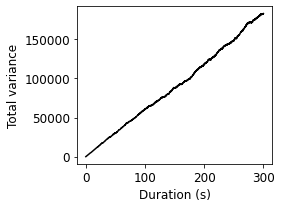

In [13]:
# compute how variance of point cloud changes over time
v = np.nan*np.zeros(len(t))

for ct in range(len(t)):
    
    v[ct] = np.trace(np.cov(rs[:, ct, :], rowvar=False))
    
fig, ax = plt.subplots(1, 1, figsize=(4, 3), tight_layout=True)
ax.plot(t, v, c='k')
set_plot(ax, x_label='Duration (s)', y_label='Total variance')